<a href="https://colab.research.google.com/github/BHouwens/kitchen_sink/blob/main/Tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tabular**

Tabular modeling takes data in the form of a table (like a spreadsheet or CSV), where the objective is to predict the value in one column based on the values in the other columns. This notebook will serve as a boilerplate handler for tabular data modeling, with sections laid out for each major step of the modeling process.

..


---



**REMEMBER**: This boilerplate is just that: boilerplate! It's a good idea to perform your own exploration in a manner that's specific to your given dataset. The default boilerplate uses the Titanic dataset from Kaggle as an example.

## **Setup**

This is the section for setting up your work environment, with boilerplate setups for a number of mainstream options. Don't see one you like? Add your own!

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
# export
COLOURS = {
    'Reset': "\x1b[0m",
    'Bright': "\x1b[1m",
    'Dim': "\x1b[2m",
    'Underscore': "\x1b[4m",
    'Blink': "\x1b[5m",
    'Reverse': "\x1b[7m",
    'Hidden': "\x1b[8m",
    'FgBlack': "\x1b[30m",
    'FgRed': "\x1b[31m",
    'FgGreen': "\x1b[32m",
    'FgYellow': "\x1b[33m",
    'FgBlue': "\x1b[34m",
    'FgMagenta': "\x1b[35m",
    'FgCyan': "\x1b[36m",
    'FgWhite': "\x1b[37m",
    'BgBlack': "\x1b[40m",
    'BgRed': "\x1b[41m",
    'BgGreen': "\x1b[42m",
    'BgYellow': "\x1b[43m",
    'BgBlue': "\x1b[44m",
    'BgMagenta': "\x1b[45m",
    'BgCyan': "\x1b[46m",
    'BgWhite': "\x1b[47m"
}

def pretty_log(msg, msg_type='info'):
  print("")
  print("{c}//===== {m} =====//{r}".format(c=COLOURS['FgBlue'], m=msg, r=COLOURS['Reset']))
  print("")

### **Imports and Installs**

Declare all your project's required imports and installs here:

In [3]:
# Installs
!pip install -Uqq fastai waterfallcharts treeinterpreter dtreeviz

     |████████████████████████████████| 204kB 31.1MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 


In [4]:
# Imports
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import numpy as np
import math
import seaborn as sn
from scipy import stats
import xgboost as xgb

In [ ]:
# Statsmodels install (only necessary if module is needed and Colab gives trouble)
! pip install --upgrade Cython
! pip install --upgrade git+https://github.com/statsmodels/statsmodels

In [ ]:
# Set up some constraints here, if desired
pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

### **Colab Setup**

You can set up the Google Colab environment for data by mounting your Google Drive:

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/My Drive/

Mounted at /content/gdrive
/content/gdrive/My Drive




---



## **Data Collection**

Data specific to your current task can be collected here. There'll be different setups depending on where you're running this notebook, but the output here will be used for further data exploration.

### **Kaggle Datasets**

Get yourself started with some Kaggle datasets. First, set up your API credentials:

In [ ]:
creds = {"username":"USERNAME_HERE","key":"API_KEY_HERE"}

Then set the credentials up in the `kaggle.json` so that Kaggle knows where to look for them in API calls:

In [ ]:
!mkdir .kaggle
!mv .kaggle /root/
!touch /root/.kaggle/kaggle.json

!ls /root/.kaggle

kaggle.json


Then write the credentials to `kaggle.json` with the correct permissions setup to enable access to Kaggle datasets:

In [ ]:
import json
import zipfile
import os

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(creds, file)

!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!export KAGGLE_CONFIG_DIR=/root/.kaggle/kaggle.json

Before we finally install Kaggle itself:

In [ ]:
!pip install kaggle

In [ ]:
from kaggle import api

Now let's fetch our Kaggle data:

In [ ]:
if not os.path.exists('data'):
  os.makedirs('data')

# Let's get the Titanic dataset
api.competition_download_files('titanic', path='data')

import zipfile
with zipfile.ZipFile("data/titanic.zip","r") as zip_ref:
    zip_ref.extractall("data")

os.remove('data/titanic.zip')
os.remove('data/gender_submission.csv')

In [ ]:
!ls data

df_without_te.pkl  tdf.pkl  tdf_with_te.pkl  test.csv  train.csv


Finally, let's set up some variables for taking the data exploration further:

In [6]:
path = "data"
train_data = "train.csv"
test_data = "test.csv"



---



## **Exploratory Data Analysis**

EDA can be performed here, where you'll find cells for showing batches, as well as utility functions for displaying certain analytics. It also contains headings to prompt some thinking about possible exploratory approaches. For tabular data in particular, this section will include tree classifiers for model/data fit inspection.

**REMEMBER**: This section is not prescriptive! Add and remove from it as you want and need to.

### **Look at the Data**

In [7]:
# Let's mark our dependent variable
DEP_VAR = "Survived"

In [8]:
# Setup the dataset path
train_path = "{b}/{d}".format(b=path, d=train_data)
test_path = "{b}/{d}".format(b=path, d=test_data)

# And read it in to a df
train_df = pd.read_csv(train_path, low_memory=False)
test_df = pd.read_csv(test_path, low_memory=False)

In [10]:
# Set a "reset" df, in case we want to reset the data 
reset_train = train_df.copy(deep=True)
reset_test = test_df.copy(deep=True)

In [ ]:
# export
def get_col_diff(df1, df2):
  """
  Gets the difference in columns between 2 dataframes
  """
  # Inefficient, but should be fine for something like column input
  fir_set = [i for i in df1.columns if i not in df2.columns]
  sec_set = [i for i in df2.columns if i not in df1.columns]

  return fir_set, sec_set

In [ ]:
# Let's get some info about the general structure between train and test
print("TRAIN COLS", list(test_df.columns))
print("TEST COLS", list(train_df.columns))

fir, sec = get_col_diff(train_df, test_df)

pretty_log("GENERAL INFO")
print("Columns not in train (this should be empty):", sec)
print("Columns not in test (this should be the dependent variable):", fir)
print("Test set is {}% the size of train".format(round(len(test_df) / len(train_df) * 100, 2)))
pretty_log("")

TRAIN COLS ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
TEST COLS ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

//===== GENERAL INFO =====//

Columns not in train (this should be empty): []
Columns not in test (this should be the dependent variable): ['Survived']
Test set is 46.91% the size of train

//=====  =====//



We can also create a concatenated `DataFrame` of train and test so that we can do things like exploration and feature engineering on the full set.

In [ ]:
full_df = pd.concat([train_df, test_df], sort=True).reset_index(drop=True)

len(full_df)

1309

We can a bit of a description of our dataset using `df.describe()`

In [ ]:
full_df.describe()

,Age,Fare,Parch,PassengerId,Pclass,SibSp,Survived
count,1046.000000,1308.000000,1309.000000,1309.000000,1309.000000,1309.000000,891.000000
mean,29.881138,33.295479,0.385027,655.000000,2.294882,0.498854,0.383838
std,14.413493,51.758668,0.865560,378.020061,0.837836,1.041658,0.486592
min,0.170000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,21.000000,7.895800,0.000000,328.000000,2.000000,0.000000,0.000000
50%,28.000000,14.454200,0.000000,655.000000,3.000000,0.000000,0.000000
75%,39.000000,31.275000,0.000000,982.000000,3.000000,1.000000,1.000000
max,80.000000,512.329200,9.000000,1309.000000,3.000000,8.000000,1.000000


It's always important to take a look at some of the entries themselves so that we can develop a better intuition for what we're working with.

In [ ]:
full_df.head(20)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
6,54.0,E46,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463
7,2.0,NaN,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909
8,27.0,NaN,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742
9,14.0,NaN,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736


We can also view the interactions between all possible feature pairs. This isn't necessarily doable for larger datasets, but for the sake of our example it can be done for all features directly:

In [ ]:
# Create the default pairplot
sn.pairplot(df)

We can see `NaN` values, which we'll need to decide how we want to handle, as well as pick out any potentially interesting features based on their values. It may also be useful to pick out "magic features", those which have a strong correlation to the target given some relatively simple transformation.

### **Handling Missing Values**

It's extremely common to find missing content in datasets and it's important to decide how to handle these. Some libraries, like fastai, do have built in handlers for this, but may be different from those found in something like Pandas.

In [ ]:
# Any mistakes in handling missing values can be reset to the original dataset here
full_reset_df = full_df.copy(deep=True)

In [ ]:
full_df = full_reset_df.copy(deep=True)

In [ ]:
# We can first find which columns contain NaN values
print(full_df.columns[full_df.isna().any()].tolist())

pretty_log("MISSING IN TRAIN")
print(train_df.columns[train_df.isna().any()].tolist())

pretty_log("MISSING IN TEST")
print(test_df.columns[test_df.isna().any()].tolist())

['Age', 'Cabin', 'Embarked', 'Fare', 'Survived']

//===== MISSING IN TRAIN =====//

['Age', 'Cabin', 'Embarked']

//===== MISSING IN TEST =====//

['Age', 'Fare', 'Cabin']


Okay, now that we know which columns are missing in each set, we can go about solving this issue for the full set.

In [ ]:
# export
def get_missing_info_for_col(df, col):
  missing = df[col].isnull().sum()
  print("Missing volume for {c} in dataset: {v}".format(c=col, v=missing))
  print("Missing volume in percentage:", str(round(missing / len(df) * 100, 2)) + "%")

In [ ]:
# export
def mark_nan_cols(df):
  """
  Creates a new column for each NaN column in the df, 
  marking whether the row contained a NaN or not
  """
  nan_cols = df.columns[df.isna().any()].tolist()

  for col in nan_cols:
    df["{}_NaN".format(col)] = np.where(df[col].isnull(), 1, 0)

We can mark the existence of `NaN` in a row-column pair by creating a new column for each of the columns that contain `NaN`. In each of these new columns, if there was a `NaN` in that row we'll mark it with a 1 and if not we'll mark with a 0.

In [ ]:
# Let's mark the missing columns as a new boolean column
mark_nan_cols(full_df)

Now let's start with Age:

In [ ]:
pretty_log("AGE in FULL DATASET")
get_missing_info_for_col(full_df, 'Age')


//===== AGE in FULL DATASET =====//

Missing volume for Age in dataset: 263
Missing volume in percentage: 20.09%


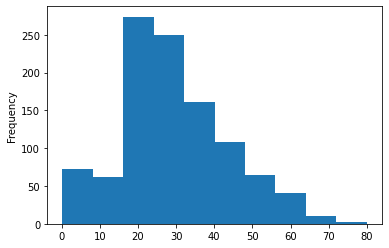

In [ ]:
full_df['Age'].plot(kind='hist')

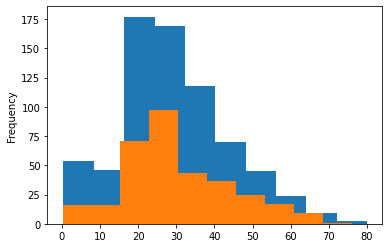

In [ ]:
# Let's check the distribution between train and test sets
train_df['Age'].plot(kind='hist')
test_df['Age'].plot(kind='hist')

The distribution between the train and test sets for age isn't perfect. Do we possibly need to think about how to deal with this?

In [ ]:
fir_class = full_df.loc[full_df['Pclass'] == 1]["Age"]
sec_class = full_df.loc[full_df['Pclass'] == 2]["Age"]
thi_class = full_df.loc[full_df['Pclass'] == 3]["Age"]

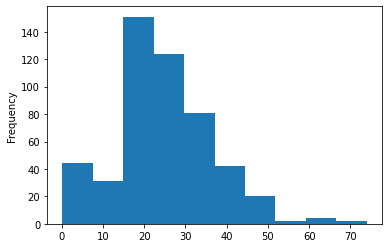

In [ ]:
thi_class.plot(kind="hist")

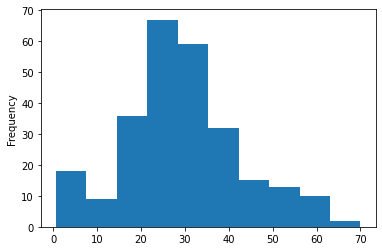

In [ ]:
sec_class.plot(kind='hist')

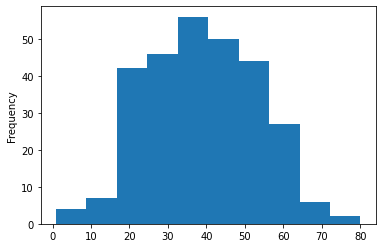

In [ ]:
fir_class.plot(kind='hist')

In [ ]:
# Fill with median (in this case we'll groupby to get the median by group)
full_df['Age'] = full_df.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.median()))

In [ ]:
full_df.columns[full_df.isna().any()].tolist()

['Cabin', 'Embarked', 'Fare', 'Survived']

Great, age is no longer a `NaN`-containing column. Next we can look at the fare:

In [ ]:
full_df.loc[full_df['Fare'].isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_NaN,Cabin_NaN,Embarked_NaN,Fare_NaN,Survived_NaN
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701,0,1,0,1,1


There's only one guy in the whole dataset who doesn't have a recorded fare. Mr. Thomas was in passenger class 3, travelled alone and embarked in Southhampton. We will take other cases from people in this category and replace the missing Fare with the median of this group

In [ ]:
# Let's get the median of people in a similar situation
thomas = full_df.loc[(full_df['Pclass'] == 3) & (full_df['Embarked'] == 'S') & (full_df['SibSp'] == 0)]['Fare'].median()
print(thomas)

7.925


In [ ]:
full_df.loc[full_df['Fare'].isnull(), 'Fare'] = thomas

In [ ]:
full_df.columns[full_df.isna().any()].tolist()

['Cabin', 'Embarked', 'Survived']

Great, that takes care of our missing Fare! Now let's look at Cabin. This is a tricky one as we're dealing with categorical variable.

In [ ]:
full_df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [ ]:
def extract_nums_from_cabin(entry):
  sets = entry.split()
  int_sets = []

  final_num = 0
  for c in sets:
    extraction = [s for s in list(c) if s.isdigit()]

    if len(extraction) > 0:
      int_sets.append(int(''.join(extraction)))
    else:
      int_sets.append(0)
  
  return sum(int_sets) / len(int_sets)

In [ ]:
# Let's keep the first letter from the cabin in a new variable (see Titanic layout) and replace missings with 'M'
full_df['Deck'] = full_df['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'M')

# The cabin number probably has something to do with they were in the bow or stern of the ship, so we'll keep that too
full_df['Ship_Pos'] = full_df['Cabin'].apply( lambda x: extract_nums_from_cabin(x) if pd.notnull(x) else None )
full_df['Ship_Pos'].fillna(full_df['Ship_Pos'].median(), inplace=True)

Let's plot survival rate by deck and see whether there is some kind of pattern we can pull out.

Text(0.5, 0.98, 'Survival rate by cabin')

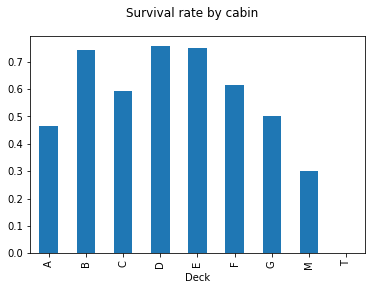

In [ ]:
full_df[['Deck', 'Survived']].groupby('Deck')['Survived'].mean().plot(kind="bar")
plt.suptitle('Survival rate by cabin')

The survival for certain groupings seems higher, which makes sense given that first class passengers, for example, were probably quicker to the lifeboats.

In [ ]:
idx = full_df[full_df['Deck'] == 'T'].index
full_df.loc[idx, 'Deck'] = 'A'

full_df['Deck'] = full_df['Deck'].replace(['A', 'B', 'C'], 'ABC')
full_df['Deck'] = full_df['Deck'].replace(['D', 'E'], 'DE')
full_df['Deck'] = full_df['Deck'].replace(['F', 'G'], 'FG')

full_df['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

Let's now also take a look at where the passengers were in terms of their position on the ship, since the Titanic sank in one section first:

Text(0.5, 0.98, 'Survival rate by position on ship')

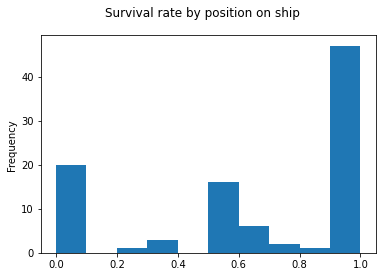

In [ ]:
full_df[['Ship_Pos', 'Survived']].groupby('Ship_Pos')['Survived'].mean().plot(kind='hist')
plt.suptitle('Survival rate by position on ship')

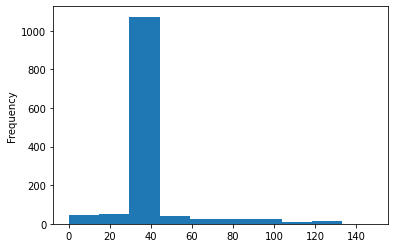

In [ ]:
full_df['Ship_Pos'].plot(kind='hist')

Although most people seem to have clustered around the 20 - 60 room range, it looks like the survival rate for those nearer the back of the ship was far higher.

In [ ]:
full_df['Survival_Pos'] = np.where(full_df['Ship_Pos'] > 120, 1, 0)

In [ ]:
# Let's finally drop the original cabin column
full_df.drop('Cabin', inplace=True, axis=1, errors='ignore')

In [ ]:
# Quick check again
full_df.columns[full_df.isna().any()].tolist()

['Embarked', 'Survived']

Okay, only the Embarked column remains.

In [ ]:
full_df.loc[full_df['Embarked'].isnull()]

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_NaN,Cabin_NaN,Embarked_NaN,Fare_NaN,Survived_NaN,Deck,Ship_Pos,Survival_Pos
61,38.0,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572,0,0,1,0,0,ABC,28.0,0
829,62.0,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572,0,0,1,0,0,ABC,28.0,0


Thankfully there are only 2 missing values here, and again we can use the same strategy that we used on Fare by giving the median of all somewhat related passengers to those missing. Thankfully, in this particular case we can also look up some background information about these 2 ladies and discover that both boarded in [Southampton](https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html):

In [ ]:
full_df.loc[full_df['Embarked'].isnull(), 'Embarked'] = 'S'

In [ ]:
# Final check
full_df.columns[full_df.isna().any()].tolist()

['Survived']

Finally, we got 'em all! Only the dependent variable still contains `NaN` values, which is to be expected since we're looking over the entire dataset.

### **Handling Dates**

Dates often pose a challenge from an encoding point of view. They often have a lot of semantic meaning to us though (did it occur on a weekend? a holiday? etc), so we may want to encode special properties of the dates in the dataset.

In [ ]:
# Example from fast.ai Tabular core
date_df = pd.DataFrame({'date': ['2019-12-04', None, '2019-11-15', '2019-10-24']})
date_df = add_datepart(date_df, 'date')
date_df.head()

Further date-related features can be built if there is something specifically relevant to our project. For example, do we care about sales in a specific holiday season, or is a particular virus infection rate seasonal? 

### **Handling Rank in Ordinal Columns**

Some categorical data will be ranked (*ordinal columns*), and for these features it may be useful to tell Pandas about how these categories are ordered.

In [ ]:
# As an example, let's take the passenger class for the Titanic dataset
full_df['Pclass'].unique()

array([3, 1, 2])

In [ ]:
full_df['Deck'].unique()

array(['M', 'ABC', 'DE', 'FG'], dtype=object)

In [ ]:
# export 
def define_ordinal_rank(df, col, ranks):
  """
  Defines ordinal ranking of a column in a dataset

  Args:
    df: DataFrame to define for
    col: Column to define for
    ranks: An array of the ordinal ranking for col
  """
  df[col] = df[col].astype('category')
  df[col].cat.set_categories(ranks, ordered=True, inplace=True)

In [ ]:
define_ordinal_rank(full_df, 'Pclass', [1, 2, 3])

In [ ]:
define_ordinal_rank(full_df, 'Deck', ['ABC', 'DE', 'FG', 'M'])

### **Automated Data Checks and Processing**

Some simple checks can be made on the dataset automatically, depending on what it is you're looking for. In addition, certain types of augmentation or processing can be performed on the data in an automated fashion.

#### **Roulette Target**

A "roulette" occurs when there are duplicate rows with different target values. This makes training much more difficult, as target values may be close to random.

To start, we'll need to define some kind of acceptable amount of duplicates within the system. This should be generally okay as it's possible that some external, non-codified features have an effect on the target variable. So first we define an acceptable proportion of the dataset as duplicates:

In [ ]:
ACCEPTANCE_THRES = .02

And then we have two options. One is to do a simple check on the proportion of duplicates in the dataset and match it against our accepted proportion threshold. We do not consider rows that are full duplicates (that is they duplicate both the row values and the targets) so let's first set up a function to find the relevant duplicates:

In [ ]:
# export
def get_relevant_duplicates(df, dep_var):
  """
  Gets number of duplicates with differing targets
  """
  ind_var = [c for c in df.columns if c != dep_var]

  # We need to sift out full duplicate rows
  poss_dups = df.duplicated(ind_var).sum()
  full_dups = df.duplicated().sum()
  return poss_dups - full_dups

And then we can implement our simple solution:

In [ ]:
# Naive, workable solution
relevant_dups = get_relevant_duplicates(full_df, DEP_VAR)
is_roulette = (relevant_dups / len(full_df) * 100) > ACCEPTANCE_THRES

print("Dataset is a roulette:", is_roulette)

Dataset is a roulette: False


This approach can work. A more rigorous approach is to apply a statistical hypothesis test against the accepted threshold and see if that holds up!

For this simple test we claim that the dataset is not a roulette ($H_0$) and perform a [1-proportion test](https://www.tutorialspoint.com/statistics/one_proportion_z_test.htm) to find the associated p-value for this hypothesis. Our alternative hypothesis is that our dataset contains fewer relevant duplicates than our accepted threshold:

In [ ]:
# export
import statsmodels.api as sm

ALPHA = .05

def roulette_test(df, dep_var, threshold):
  """
  Performs a 1-proportion z-test on df to check for roulette. 
  Null hypothesis is that the number of duplicates do not 
  constitute a roulette dataset, in that the number is lower than 
  the acceptance threshold
  """
  relevant_dups = get_relevant_duplicates(df, dep_var)
  if relevant_dups == 0: return False

  _, p_val = sm.stats.proportions_ztest(
      relevant_dups, len(df), len(df)*threshold, 'smaller')

  return p_val > ALPHA

In [ ]:
is_roulette = roulette_test(df, dep_var, ACCEPTANCE_THRES)
print("Dataset is a roulette:", is_roulette)

This check may or may not be relevant depending on the context of the dataset. Consider an actual roulette wheel's results or the results of a series of horse races, which may in fact contain a number of full duplicates that is higher than our threshold. In such a scenario, it would be beneficial to know before pursuing such a data science project further, as the dataset's value entropy may be too high to warrant further work.

#### **Highly Correlated Features**

Some features within the dataset may be highly correlated, and we may want to check for these and then make some decision about them.

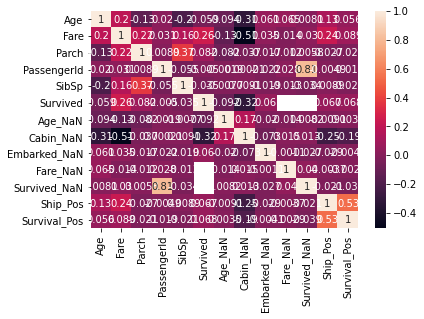

In [ ]:
import seaborn as sn

corrMatrix = full_df.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

### **Feature Engineering**

Here we can do some feature engineering in order to improve the model's eventual understanding of the data.

#### **Feature Interactions**

We can calculate some feature interactions based on the types of features that we have, in order to prompt the model to look at their relationships.

In [ ]:
# We can start by creating some interactions
full_df['Age_Fare'] = full_df.apply(lambda row: row.Age * row.Fare, axis=1)
full_df['Age_Fare']

0        159.5000
1       2708.7654
2        206.0500
3       1858.5000
4        281.7500
          ...    
1304     201.2500
1305    4247.1000
1306     279.1250
1307     201.2500
1308     558.9575
Name: Age_Fare, Length: 1309, dtype: float64

We may also need to specify interesting interactions based on the specifics of our datasets

In [ ]:
def is_female_and_high_class(row):
  if row.Sex == "female" and row.Pclass < 2:
    return 1
  return 0
 
full_df['Fem_HC'] = full_df.apply(is_female_and_high_class, axis=1)
full_df['Fem_HC'].head(10)

0    0
1    1
2    0
3    1
4    0
5    0
6    0
7    0
8    0
9    0
Name: Fem_HC, dtype: int64

In [ ]:
def has_no_cabin_and_male(row):
  if row.Sex == "male" and row.Cabin_NaN == 1:
    return 1
  return 0

full_df['Mal_CNaN'] = full_df.apply(has_no_cabin_and_male, axis=1)
full_df['Mal_CNaN'].head()

0    1
1    0
2    0
3    0
4    1
Name: Mal_CNaN, dtype: int64

In [ ]:
def add_all_manual_features(df):
  df['Age_Fare'] = df.apply(lambda row: row.Age * row.Fare, axis=1)
  df['Fem_HC'] = df.apply(is_female_and_high_class, axis=1)
  df['Mal_CNaN'] = df.apply(has_no_cabin_and_male, axis=1)

#### **Handle Outliers**

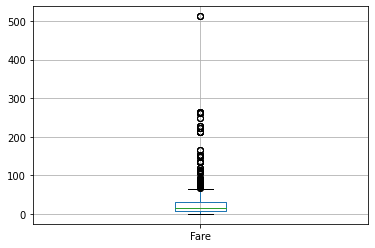

In [ ]:
full_df.boxplot(column='Fare')

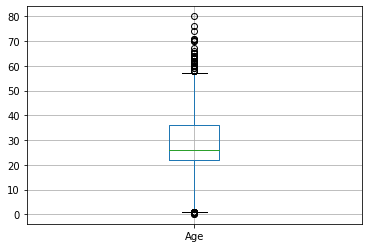

In [ ]:
full_df.boxplot(column='Age')

Okay, so we have some outliers for both Age and Fare and we want to reduce any impact they may have on our model, so we'll continue by binning these values by distribution. For Fare we will assign the same number of cases to each category and for Age we will build the categories based on the values of the variable. This is also the difference between [cut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html) and [qcut](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html). With `cut`, the bins are formed based on the values of the variable, regardless of how many cases fall into a category. With `qcut` we decompose a distribution so that there are the same number of cases in each category.

In [ ]:
full_df['Age_Cut'] = pd.cut(full_df['Age'].astype(int), 5)
full_df['Fare_Cut'] = pd.qcut(full_df['Fare'], 5)

In [ ]:
# For Age, each category has a different number of classes:
full_df['Age_Cut'].value_counts()

(16.0, 32.0]     752
(32.0, 48.0]     304
(-0.08, 16.0]    134
(48.0, 64.0]     106
(64.0, 80.0]      13
Name: Age_Cut, dtype: int64

In [ ]:
# For Fare, they are nearly the same
full_df['Fare_Cut'].value_counts()

(-0.001, 7.854]      275
(21.558, 41.579]     265
(41.579, 512.329]    259
(10.5, 21.558]       255
(7.854, 10.5]        255
Name: Fare_Cut, dtype: int64

#### **Some Exploration**

We expect a correlation between ticket frequencies and survival rates, because identical ticket numbers are an indicator that people have travelled together.

In [ ]:
full_df['Ticket_Freq'] = full_df.groupby('Ticket')['Ticket'].transform('count')
full_df['Ticket_Freq'].value_counts()

1     713
2     264
3     147
4      64
7      35
5      35
6      24
8      16
11     11
Name: Ticket_Freq, dtype: int64

In [ ]:
full_df[['Ticket_Freq', 'Survived']].groupby('Ticket_Freq').mean()

,Survived
Ticket_Freq,
1,0.270270
2,0.513812
3,0.653465
4,0.727273
5,0.333333
6,0.210526
7,0.208333
8,0.384615
11,0.000000


There definitely seems to be a difference in survival rate depending on ticket frequency. Interesting.

Now let's take a look at potentially pulling out the title of an individual, as this could be a good marker for socio-economic status (married or unmarried) and therefore give us clues about whether or not their survival rate was likely to be higher.

In [ ]:
full_df['Name'].head(10)

0                                Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Thayer)
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
5                                       Moran, Mr. James
6                                McCarthy, Mr. Timothy J
7                         Palsson, Master. Gosta Leonard
8      Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                    Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [ ]:
full_df[full_df['Name'].str.contains("Palsson")]

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Age_NaN,Cabin_NaN,Embarked_NaN,Fare_NaN,Survived_NaN,Deck,Ship_Pos,Survival_Pos,Age_Fare,Fem_HC,Mal_CNaN,Age_Cut,Fare_Cut,Ticket_Freq
7,2.0,S,21.075,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,0,1,0,0,0,M,38.0,0,42.150,0,1,"(-0.08, 16.0]","(10.5, 21.558]",5
24,8.0,S,21.075,"Palsson, Miss. Torborg Danira",1,25,3,female,3,0.0,349909,0,1,0,0,0,M,38.0,0,168.600,1,0,"(-0.08, 16.0]","(10.5, 21.558]",5
374,3.0,S,21.075,"Palsson, Miss. Stina Viola",1,375,3,female,3,0.0,349909,0,1,0,0,0,M,38.0,0,63.225,1,0,"(-0.08, 16.0]","(10.5, 21.558]",5
567,29.0,S,21.075,"Palsson, Mrs. Nils (Alma Cornelia Berglund)",4,568,3,female,0,0.0,349909,0,1,0,0,0,M,38.0,0,611.175,1,0,"(16.0, 32.0]","(10.5, 21.558]",5
1280,6.0,S,21.075,"Palsson, Master. Paul Folke",1,1281,3,male,3,NaN,349909,0,1,0,0,1,M,38.0,0,126.450,0,1,"(-0.08, 16.0]","(10.5, 21.558]",5


We can tell a lot now just by looking at familial relationships. It's unlikely that Master Paul Folke Palsson, in the test set, survived given that the rest of his family did not. This also tells us that children or the unmarried (Miss and Master) were more likely to be travelling with family and therefore were likely to share their family's fate.

In [ ]:
# Let's extract the surname, as this may allows us to match families
full_df['Surname'] = full_df['Name'].str.split(', ', expand=True)[0]

full_df['Surname'].head()

0       Braund
1      Cumings
2    Heikkinen
3     Futrelle
4        Allen
Name: Surname, dtype: object

In [ ]:
# Then let's extract the title of the individual
full_df['Title'] = full_df['Name'].str.split(', ', expand=True)[1].str.split('. ', expand=True)[0]
full_df['Is_Married'] = np.where((full_df['Title'] == 'Mrs') | (full_df['Title'] == 'Mr'), 1, 0)

full_df[['Is_Married', 'Name', 'Title']].head(10)

,Is_Married,Name,Title
0,1,"Braund, Mr. Owen Harris",Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",Mrs
2,0,"Heikkinen, Miss. Laina",Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,1,"Allen, Mr. William Henry",Mr
5,1,"Moran, Mr. James",Mr
6,1,"McCarthy, Mr. Timothy J",Mr
7,0,"Palsson, Master. Gosta Leonard",Master
8,1,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",Mrs
9,1,"Nasser, Mrs. Nicholas (Adele Achem)",Mrs


In [ ]:
def is_young_male(row):
  if row.Sex == "male" and row.Is_Married == 0:
    return 1
  return 0

full_df['Male_Young'] = full_df.apply(is_young_male, axis=1)

In [ ]:
# We'll need to handle cases where the median fill value for a NaN age doesn't align with the Master title
def reset_master_age(row):
  if row.Title == "Master" and row.Age > 18:
    return 17
  return row.Age

full_df['Age'] = full_df.apply(reset_master_age, axis=1)

In [ ]:
full_df[full_df['Surname'].str.contains("Kiernan")]

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Age_NaN,Cabin_NaN,Deck,Ship_Pos,Age_Fare,Fem_HC,Mal_CNaN,Age_Cut,Fare_Cut,Ticket_Freq,Title,Is_Married,Surname,Male_Young
214,25.0,Q,7.75,0,3,male,1,0.0,1,1,M,38.0,193.75,0,1,"(16.0, 32.0]","(-0.001, 7.854]",1,Mr,1,Kiernan,0
1012,25.0,Q,7.75,0,3,male,1,NaN,1,1,M,38.0,193.75,0,1,"(16.0, 32.0]","(-0.001, 7.854]",1,Mr,1,Kiernan,0


At this point we can also drop the related features from before the engineering phase:

In [ ]:
full_df.drop(['Ticket', 'Name', 'Survived_NaN', 'PassengerId'], inplace=True, axis=1, errors='ignore')

#### **Target Encoding**

We can also do some target encoding for categorical inputs. This won't always be a worthwhile approach, but it's worth trying out.

In [ ]:
# Let's start by saving the current data state before continuing with target encoding
save_pickle("{}/df_without_te.pkl".format(path),full_df)

In [ ]:
full_df = load_pickle("{}/df_without_te.pkl".format(path))

full_df.head(10)

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Age_NaN,Cabin_NaN,Deck,Ship_Pos,Age_Fare,Fem_HC,Mal_CNaN,Age_Cut,Fare_Cut,Ticket_Freq,Title,Is_Married,Surname,Male_Young
0,22.0,S,7.2500,0,3,male,1,0.0,0,1,M,38.0,159.5000,0,1,"(16.0, 32.0]","(-0.001, 7.854]",1,Mr,1,Braund,0
1,38.0,C,71.2833,0,1,female,1,1.0,0,0,ABC,85.0,2708.7654,1,0,"(32.0, 48.0]","(41.579, 512.329]",2,Mrs,1,Cumings,0
2,26.0,S,7.9250,0,3,female,0,1.0,0,1,M,38.0,206.0500,0,0,"(16.0, 32.0]","(7.854, 10.5]",1,Miss,0,Heikkinen,0
3,35.0,S,53.1000,0,1,female,1,1.0,0,0,ABC,123.0,1858.5000,1,0,"(32.0, 48.0]","(41.579, 512.329]",2,Mrs,1,Futrelle,0
4,35.0,S,8.0500,0,3,male,0,0.0,0,1,M,38.0,281.7500,0,1,"(32.0, 48.0]","(7.854, 10.5]",1,Mr,1,Allen,0
5,25.0,Q,8.4583,0,3,male,0,0.0,1,1,M,38.0,211.4575,0,1,"(16.0, 32.0]","(7.854, 10.5]",1,Mr,1,Moran,0
6,54.0,S,51.8625,0,1,male,0,0.0,0,0,DE,46.0,2800.5750,0,0,"(48.0, 64.0]","(41.579, 512.329]",2,Mr,1,McCarthy,0
7,2.0,S,21.0750,1,3,male,3,0.0,0,1,M,38.0,42.1500,0,1,"(-0.08, 16.0]","(10.5, 21.558]",5,Master,0,Palsson,1
8,27.0,S,11.1333,2,3,female,0,1.0,0,1,M,38.0,300.5991,0,0,"(16.0, 32.0]","(10.5, 21.558]",3,Mrs,1,Johnson,0
9,14.0,C,30.0708,0,2,female,1,1.0,0,1,M,38.0,420.9912,0,0,"(-0.08, 16.0]","(21.558, 41.579]",2,Mrs,1,Nasser,0


In [ ]:
len(full_df)

1309

In [ ]:
# Let's take a look at what columns are present
list(full_df.columns)

['Age',
 'Embarked',
 'Fare',
 'Parch',
 'Pclass',
 'Sex',
 'SibSp',
 'Survived',
 'Age_NaN',
 'Cabin_NaN',
 'Deck',
 'Ship_Pos',
 'Age_Fare',
 'Fem_HC',
 'Mal_CNaN',
 'Age_Cut',
 'Fare_Cut',
 'Ticket_Freq',
 'Title',
 'Is_Married',
 'Surname',
 'Male_Young']

In [ ]:
def target_encoding(df, feature, target=DEP_VAR, agg_functions={"mean","std"}):
    agg=df.groupby(feature)[target].agg(agg_functions)
    agg.columns=[column+"_per_{}_{}".format(feature,target) for column in agg.columns.tolist()]
    return agg

This is only useful if we use a subset of the training set to try and encode features, because if we try to use the entire training set we will introduce massive data leakage. It's also better to apply target encoding only to categorical columns with high cardinality.

In [ ]:
full_df['Surname'].unique()

array(['Braund', 'Cumings', 'Heikkinen', 'Futrelle', 'Allen', 'Moran',
       'McCarthy', 'Palsson', 'Johnson', 'Nasser', 'Sandstrom', 'Bonnell',
       'Saundercock', 'Andersson', 'Vestrom', 'Hewlett', 'Rice',
       'Williams', 'Vander Planke', 'Masselmani', 'Fynney', 'Beesley',
       'McGowan', 'Sloper', 'Asplund', 'Emir', 'Fortune', "O'Dwyer",
       'Todoroff', 'Uruchurtu', 'Spencer', 'Glynn', 'Wheadon', 'Meyer',
       'Holverson', 'Mamee', 'Cann', 'Nicola-Yarred', 'Ahlin', 'Turpin',
       'Kraeff', 'Laroche', 'Devaney', 'Rogers', 'Lennon', "O'Driscoll",
       'Samaan', 'Arnold-Franchi', 'Panula', 'Nosworthy', 'Harper',
       'Faunthorpe', 'Ostby', 'Woolner', 'Rugg', 'Novel', 'West',
       'Goodwin', 'Sirayanian', 'Icard', 'Harris', 'Skoog', 'Stewart',
       'Moubarek', 'Nye', 'Crease', 'Kink', 'Jenkin', 'Hood',
       'Chronopoulos', 'Bing', 'Moen', 'Staneff', 'Moutal', 'Caldwell',
       'Dowdell', 'Waelens', 'Sheerlinck', 'McDermott', 'Carrau', 'Ilett',
       'Backstrom

In [ ]:
from sklearn.model_selection import train_test_split

te_df = full_df[0:len(train_df)].copy(deep=True)
train, test = train_test_split(te_df, random_state=42, test_size=.2)
train_VTE, val_VTE = train_test_split(train,random_state=42,test_size=0.1)
test_VTE = test.copy(deep=True)

categorical_features = ['Surname']

def add_target_encoding_features_validation(train, val, test):
    aggs = {}
    for feature in categorical_features:
        agg = target_encoding(train, feature)
        aggs[feature] = agg

        train = train.merge(agg, how="left", on=feature)
        val = val.merge(agg, how="left", on=feature)
        test = test.merge(agg, how="left", on=feature)
        
    return train, val, test, aggs

train_VTE, val_VTE, test_VTE, all_aggs = add_target_encoding_features_validation(train_VTE, val_VTE, test_VTE)

stitch = pd.concat([train_VTE, val_VTE, test_VTE]).reset_index(drop=True)

print(len(stitch))
print(len(te_df))

stitch.head()

891
891


,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Age_NaN,Cabin_NaN,Deck,Ship_Pos,Age_Fare,Fem_HC,Mal_CNaN,Age_Cut,Fare_Cut,Ticket_Freq,Title,Is_Married,Surname,Male_Young,std_per_Surname_Survived,mean_per_Surname_Survived
0,1.0,S,46.9000,2,3,male,5,0.0,0,1,M,38.0,46.9000,0,1,"(-0.08, 16.0]","(41.579, 512.329]",8,Master,0,Goodwin,1,0.0,0.0
1,25.0,S,9.5000,0,3,male,0,0.0,1,1,M,38.0,237.5000,0,1,"(16.0, 32.0]","(7.854, 10.5]",1,Mr,1,van Melkebeke,0,NaN,0.0
2,50.0,S,13.0000,0,2,male,0,0.0,0,1,M,38.0,650.0000,0,1,"(48.0, 64.0]","(10.5, 21.558]",1,Mr,1,Hodges,0,NaN,0.0
3,47.0,S,25.5875,0,1,male,0,0.0,0,0,DE,58.0,1202.6125,0,0,"(32.0, 48.0]","(21.558, 41.579]",1,Mr,1,Colley,0,NaN,0.0
4,51.0,S,77.9583,0,1,female,1,1.0,0,0,DE,11.0,3975.8733,1,0,"(48.0, 64.0]","(41.579, 512.329]",3,Mrs,1,Hogeboom,0,NaN,1.0


In [ ]:
print(stitch['std_per_Surname_Survived'].isna().sum())
print(stitch['mean_per_Surname_Survived'].isna().sum())
len(stitch)

628
175


891

In [ ]:
# Add in target encodings
def add_target_encodings_to_test_set(df):
  for feature in categorical_features:
    agg = all_aggs[feature]
    df = df.merge(agg, how="left", on=feature)

  return df

test_df = add_target_encodings_to_test_set(full_df[len(train_df):].copy(deep=True))
test_df.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Age_NaN,Cabin_NaN,Deck,Ship_Pos,Age_Fare,Fem_HC,Mal_CNaN,Age_Cut,Fare_Cut,Ticket_Freq,Title,Is_Married,Surname,Male_Young,std_per_Surname_Survived,mean_per_Surname_Survived
0,34.5,Q,7.8292,0,3,male,0,NaN,0,1,M,38.0,270.1074,0,1,"(32.0, 48.0]","(-0.001, 7.854]",1,Mr,1,Kelly,0,0.0,1.0
1,47.0,S,7.0000,0,3,female,1,NaN,0,1,M,38.0,329.0000,0,0,"(32.0, 48.0]","(-0.001, 7.854]",1,Mrs,1,Wilkes,0,NaN,NaN
2,62.0,Q,9.6875,0,2,male,0,NaN,0,1,M,38.0,600.6250,0,1,"(48.0, 64.0]","(7.854, 10.5]",1,Mr,1,Myles,0,NaN,NaN
3,27.0,S,8.6625,0,3,male,0,NaN,0,1,M,38.0,233.8875,0,1,"(16.0, 32.0]","(7.854, 10.5]",1,Mr,1,Wirz,0,NaN,NaN
4,22.0,S,12.2875,1,3,female,1,NaN,0,1,M,38.0,270.3250,0,0,"(16.0, 32.0]","(10.5, 21.558]",2,Mrs,1,Hirvonen,0,NaN,1.0


In [ ]:
full_df = pd.concat([stitch, test_df])
full_df.head()

len(full_df)

1309

In [ ]:
full_df.columns[full_df.isna().any()].tolist()

['Survived',
 'mean_per_Parch_Survived',
 'std_per_Parch_Survived',
 'mean_per_Title_Survived',
 'std_per_Title_Survived']

In [ ]:
def fill_nans_from_target_encoding(df):
  nan_cols = df.columns[df.isna().any()].tolist()

  for col in nan_cols:
    if col != DEP_VAR:
      df[col].fillna(df[col].mean(), inplace=True)

fill_nans_from_target_encoding(full_df)

full_df.columns[full_df.isna().any()].tolist()

['Survived']

In [ ]:
full_df.columns

Index(['Age', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex', 'SibSp',
       'Survived', 'Ticket', 'Age_NaN', 'Cabin_NaN', 'Embarked_NaN',
       'Fare_NaN', 'Deck', 'Ship_Pos', 'Survival_Pos', 'Age_Fare', 'Fem_HC',
       'Mal_CNaN', 'Ticket_Freq', 'Title', 'Is_Married',
       'mean_per_Age_Survived', 'std_per_Age_Survived',
       'mean_per_Embarked_Survived', 'std_per_Embarked_Survived',
       'mean_per_Fare_Survived', 'std_per_Fare_Survived',
       'mean_per_Parch_Survived', 'std_per_Parch_Survived',
       'mean_per_Pclass_Survived', 'std_per_Pclass_Survived',
       'mean_per_Sex_Survived', 'std_per_Sex_Survived',
       'mean_per_SibSp_Survived', 'std_per_SibSp_Survived',
       'mean_per_Age_NaN_Survived', 'std_per_Age_NaN_Survived',
       'mean_per_Cabin_NaN_Survived', 'std_per_Cabin_NaN_Survived',
       'mean_per_Deck_Survived', 'std_per_Deck_Survived',
       'mean_per_Fem_HC_Survived', 'std_per_Fem_HC_Survived',
       'mean_per_Mal_CNaN_Survived', 'std_per_Mal_


### **Basic Data Cleaning**

#### **Drop Rare Features**

Certain features may have too few events to provide any meaningful insight to a model, and we can remove these automatically if needed.

In [ ]:
# export
def drop_rare_features(df, thres=.95):
  """
  Drops features in the dataset that have 
  events that are too rare to be statistically useful
  """
  rare_f = []
  print("Running with threshold", thres)
  print("")

  for col in df.columns:
    if df[col].name not in df.select_dtypes(include='category').columns:
      freq = df[col].value_counts(normalize=True)
      sum_freq = df[col].sum()
              
      # should be enough to check whether the most freq is dominant
      if freq.iloc[0] >= thres:
        rare_f.append(col)
        print("\x1b[31m{c}: {v}\x1b[0m".format(c=col, v=freq.iloc[0]))
      else:
        print("{c}: {v}".format(c=col, v=freq.iloc[0]))
  
  df = df.drop(rare_f, axis=1)
  return df

#### **Final Clean Up**

In [ ]:
# Remove outliers
print("DF before:", df.shape)
print("")

df = remove_outliers(df, ['Age_Fare','Fare'])

print("")
print("DF after removing outliers", df.shape)

In [ ]:
# Drop rare features
print("DF before:", len(full_df.columns))
print("")

full_df = drop_rare_features(full_df)

print("")
print("DF after drop rare features:", len(full_df.columns))

DF before: 22

Running with threshold 0.95

Age: 0.12987012987012986
Embarked: 0.6997708174178763
Fare: 0.04583651642475172
Parch: 0.7654698242933538
Sex: 0.6440030557677616
SibSp: 0.680672268907563
Survived: 0.6161616161616161
Age_NaN: 0.799083269671505
Cabin_NaN: 0.774637127578304
Ship_Pos: 0.7776928953399541
Age_Fare: 0.016042780748663103
Fem_HC: 0.8899923605805958
Mal_CNaN: 0.5263559969442322
Ticket_Freq: 0.5446906035141329
Title: 0.5783040488922842
Is_Married: 0.7288006111535523
Surname: 0.008403361344537815
Male_Young: 0.9343009931245225

DF after drop rare features: 22


In [ ]:
get_relevant_duplicates(full_df, DEP_VAR)

8

In [ ]:
full_df[full_df[[i for i in full_df.columns if i != DEP_VAR]].duplicated(keep=False)]

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Age_NaN,Cabin_NaN,Deck,Ship_Pos,Age_Fare,Fem_HC,Mal_CNaN,Age_Cut,Fare_Cut,Ticket_Freq,Title,Is_Married,Surname,Male_Young
48,25.00,C,21.6792,0,3,male,2,0.0,1,1,M,38.0,541.980000,0,1,"(16.0, 32.0]","(21.558, 41.579]",3,Mr,1,Samaan,0
65,18.00,C,15.2458,1,3,male,1,1.0,1,1,M,38.0,381.145000,0,1,"(16.0, 32.0]","(10.5, 21.558]",3,Master,0,Moubarek,1
163,17.00,S,8.6625,0,3,male,0,0.0,0,1,M,38.0,147.262500,0,1,"(16.0, 32.0]","(7.854, 10.5]",1,Mr,1,Calic,0
180,22.00,S,69.5500,2,3,female,8,0.0,1,1,M,38.0,1530.100000,0,0,"(16.0, 32.0]","(41.579, 512.329]",11,Miss,0,Sage,0
201,25.00,S,69.5500,2,3,male,8,0.0,1,1,M,38.0,1738.750000,0,1,"(16.0, 32.0]","(41.579, 512.329]",11,Mr,1,Sage,0
214,25.00,Q,7.7500,0,3,male,1,0.0,1,1,M,38.0,193.750000,0,1,"(16.0, 32.0]","(-0.001, 7.854]",1,Mr,1,Kiernan,0
229,22.00,S,25.4667,1,3,female,3,0.0,1,1,M,38.0,560.267400,0,0,"(16.0, 32.0]","(21.558, 41.579]",5,Miss,0,Lefebre,0
241,22.00,Q,15.5000,0,3,female,1,1.0,1,1,M,38.0,341.000000,0,0,"(16.0, 32.0]","(10.5, 21.558]",2,Miss,0,Murphy,0
300,22.00,Q,7.7500,0,3,female,0,1.0,1,1,M,38.0,170.500000,0,0,"(16.0, 32.0]","(-0.001, 7.854]",1,Miss,0,Kelly,0
324,25.00,S,69.5500,2,3,male,8,0.0,1,1,M,38.0,1738.750000,0,1,"(16.0, 32.0]","(41.579, 512.329]",11,Mr,1,Sage,0


In [ ]:
print("DF before:", len(full_df))

ind_vars = [c for c in full_df.columns if c != DEP_VAR]

# Remove duplicates
full_df.drop_duplicates(subset=ind_vars, inplace=True)
print("DF after drop duplicates:", len(full_df))

DF before: 1309
DF after drop duplicates: 1288


In [ ]:
# Let's save the current state before continuing with a TabularPandas
save_pickle("{}/df_without_te.pkl".format(path),full_df)

### **Conversion to TabularPandas**

If we want to convert our dataset into a `TabularPandas` dataset from [fast.ai](https://docs.fast.ai/tabular.core.html#TabularPandas) we can do so here, specifying all the preprocessing and splitting we'd require.

In [ ]:
full_df = load_pickle("{}/df_without_te.pkl".format(path))

In [ ]:
# Start by defining procs
procs = [Categorify, Normalize]

In [ ]:
full_df_cop = full_df.copy(deep=True)

train_tb = full_df_cop[0: len(train_df)]
test_tb = full_df_cop[len(train_df):]

print("ORIGINAL TRAIN SET LENGTH", len(train_df))
print("Train", len(train_tb))
print("Test", len(test_tb))

ORIGINAL TRAIN SET LENGTH 891
Train 891
Test 418


In [ ]:
train_tb.tail()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Age_NaN,Cabin_NaN,Deck,Ship_Pos,Age_Fare,Fem_HC,Mal_CNaN,Age_Cut,Fare_Cut,Ticket_Freq,Title,Is_Married,Surname,Male_Young
886,27.0,S,13.00,0,2,male,0,0.0,0,1,M,38.0,351.0,0,1,"(16.0, 32.0]","(10.5, 21.558]",1,Rev,0,Montvila,1
887,19.0,S,30.00,0,1,female,0,1.0,0,0,ABC,42.0,570.0,1,0,"(16.0, 32.0]","(21.558, 41.579]",1,Miss,0,Graham,0
888,22.0,S,23.45,2,3,female,1,0.0,1,1,M,38.0,515.9,0,0,"(16.0, 32.0]","(21.558, 41.579]",4,Miss,0,Johnston,0
889,26.0,C,30.00,0,1,male,0,1.0,0,0,ABC,148.0,780.0,0,0,"(16.0, 32.0]","(21.558, 41.579]",1,Mr,1,Behr,0
890,32.0,Q,7.75,0,3,male,0,0.0,0,1,M,38.0,248.0,0,1,"(16.0, 32.0]","(-0.001, 7.854]",1,Mr,1,Dooley,0


In [ ]:
test_tb.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Age_NaN,Cabin_NaN,Deck,Ship_Pos,Age_Fare,Fem_HC,Mal_CNaN,Age_Cut,Fare_Cut,Ticket_Freq,Title,Is_Married,Surname,Male_Young
891,34.5,Q,7.8292,0,3,male,0,NaN,0,1,M,38.0,270.1074,0,1,"(32.0, 48.0]","(-0.001, 7.854]",1,Mr,1,Kelly,0
892,47.0,S,7.0000,0,3,female,1,NaN,0,1,M,38.0,329.0000,0,0,"(32.0, 48.0]","(-0.001, 7.854]",1,Mrs,1,Wilkes,0
893,62.0,Q,9.6875,0,2,male,0,NaN,0,1,M,38.0,600.6250,0,1,"(48.0, 64.0]","(7.854, 10.5]",1,Mr,1,Myles,0
894,27.0,S,8.6625,0,3,male,0,NaN,0,1,M,38.0,233.8875,0,1,"(16.0, 32.0]","(7.854, 10.5]",1,Mr,1,Wirz,0
895,22.0,S,12.2875,1,3,female,1,NaN,0,1,M,38.0,270.3250,0,0,"(16.0, 32.0]","(10.5, 21.558]",2,Mrs,1,Hirvonen,0


#### **Splitting**

If we have timeseries data we'll probably want to manually specify a validation set, as the sequential nature may be important to the understanding of the data:

In [ ]:
# Example splitting for timeseries
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where( cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))

Alternatively you can split randomly:

In [ ]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_tb))
splits

((#713) [132,204,285,338,316,255,750,59,679,40...],
 (#178) [31,836,538,470,761,161,317,758,81,14...])

#### **Final Setup**

For categorical data we'll want to tell `TabularPandas` which columns are categorical and which are continuous:

In [ ]:
cont,cat = cont_cat_split(train_tb, dep_var=DEP_VAR)

print("Continuous columns:", cont)
print("Categorical columns:", cat)

Continuous columns: ['Age', 'Fare', 'Ship_Pos', 'Age_Fare']
Categorical columns: ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Age_NaN', 'Cabin_NaN', 'Deck', 'Fem_HC', 'Mal_CNaN', 'Age_Cut', 'Fare_Cut', 'Ticket_Freq', 'Title', 'Is_Married', 'Surname', 'Male_Young']


In [ ]:
# Finally we set the TabularPandas df up
tdf = TabularPandas(train_tb, procs, cat, cont, y_names=DEP_VAR, splits=splits, y_block=CategoryBlock)

In [ ]:
tdf.show(5)

,Embarked,Parch,Pclass,Sex,SibSp,Age_NaN,Cabin_NaN,Deck,Fem_HC,Mal_CNaN,Age_Cut,Fare_Cut,Ticket_Freq,Title,Is_Married,Surname,Male_Young,Age,Fare,Ship_Pos,Age_Fare,Survived
782,S,0,1,male,0,0,0,DE,0,0,"(16.0, 32.0]","(21.558, 41.579]",1,Mr,1,Long,0,29.0,30.0000,6.0,870.000000,0.0
668,S,0,3,male,0,0,1,M,0,1,"(32.0, 48.0]","(7.854, 10.5]",1,Mr,1,Cook,0,43.0,8.0500,38.0,346.149994,0.0
372,S,0,3,male,0,0,1,M,0,1,"(16.0, 32.0]","(7.854, 10.5]",1,Mr,1,Beavan,0,19.0,8.0500,38.0,152.949997,0.0
670,S,1,2,female,1,0,1,M,0,0,"(32.0, 48.0]","(21.558, 41.579]",3,Mrs,1,Brown,0,40.0,39.0000,38.0,1560.000000,1.0
189,S,0,3,male,0,0,1,M,0,1,"(32.0, 48.0]","(7.854, 10.5]",1,Mr,1,Turcin,0,36.0,7.8958,38.0,284.248810,0.0


In [ ]:
tdf.items.head(5)

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Age_NaN,Cabin_NaN,Deck,Ship_Pos,Age_Fare,Fem_HC,Mal_CNaN,Age_Cut,Fare_Cut,Ticket_Freq,Title,Is_Married,Surname,Male_Young
782,-0.004649,3,-0.047447,1,1,2,1,0,1,1,2,-1.957879,-0.083524,1,1,2,4,1,12,2,354,1
668,1.035912,3,-0.475004,1,3,2,1,0,1,2,4,-0.149099,-0.359769,1,2,3,2,1,12,2,128,1
372,-0.747908,3,-0.475004,1,3,2,1,0,1,2,4,-0.149099,-0.461650,1,2,2,2,1,12,2,49,1
670,0.812935,3,0.127862,2,2,1,2,1,1,2,4,-0.149099,0.280337,1,1,3,4,3,13,2,77,1
189,0.515631,3,-0.478008,1,3,2,1,0,1,2,4,-0.149099,-0.392412,1,2,3,2,1,12,2,615,1


In [ ]:
len(tdf.train),len(tdf.valid)

(713, 178)

We can also now save the data, as we've probably done a lot of work on it up to this point.

In [ ]:
save_pickle("{}/tdf.pkl".format(path),tdf)



---



## **Model**

Model work can be performed here, with utilities to help with cross-validation and architecture construction.

In [9]:
tdf = load_pickle("{}/tdf.pkl".format(path))

In [10]:
# Let's start by setting up our separate sets
train_x, train_y = tdf.train.xs, tdf.train.y
valid_x, valid_y = tdf.valid.xs, tdf.valid.y

In [11]:
print("First train features:", train_x.iloc[0])
print("")
print("First train label:", train_y.iloc[0])

First train features: Embarked         3.000000
Parch            1.000000
Pclass           3.000000
Sex              1.000000
SibSp            2.000000
Age_NaN          1.000000
Cabin_NaN        2.000000
Deck             4.000000
Fem_HC           1.000000
Mal_CNaN         1.000000
Age_Cut          3.000000
Fare_Cut         3.000000
Ticket_Freq      2.000000
Title           13.000000
Is_Married       2.000000
Surname        515.000000
Male_Young       1.000000
Age              1.423430
Fare            -0.353035
Ship_Pos        -0.176358
Age_Fare        -0.179610
Name: 132, dtype: float64

First train label: 0


### **Baseline Tree Model**

Tabular data has not been completely dominated by neural nets, and tree models are still a viable option to model such datasets. Even if we do go with a neural net (or some ensemble) for the final model, we can still infer a lot about how a model sees the data by starting with a tree.

In [ ]:
m = DecisionTreeClassifier(max_leaf_nodes=4)
m.fit(train_x, train_y);

We can then view the results visually:

In [ ]:
tree.plot_tree(m, feature_names=train_x.columns, precision=2)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


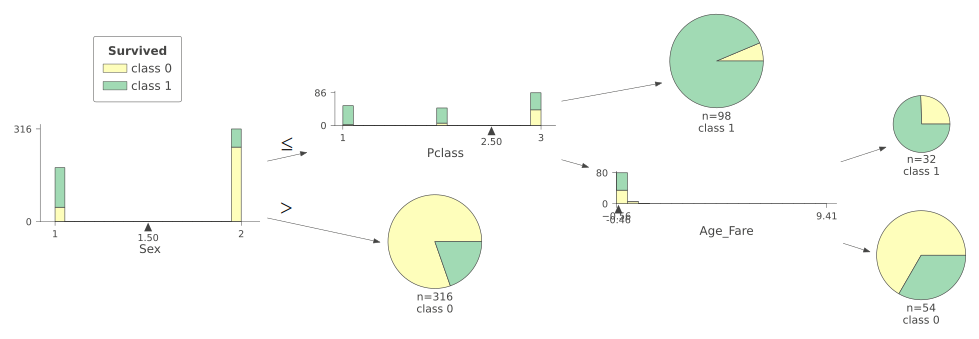

In [ ]:
# DTreeViz result
samp_idx = np.random.permutation(len(train_y))[:500]
dtreeviz(m, train_x.iloc[samp_idx], train_y.iloc[samp_idx], train_x.columns, DEP_VAR,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [12]:
m = RandomForestClassifier(n_estimators=65, max_depth=7, min_samples_split=6, min_samples_leaf=6, oob_score=True, random_state=42, verbose=True)
m.fit(train_x, train_y)

preds = m.predict(valid_x)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:    0.0s finished


In [13]:
from sklearn.metrics import accuracy_score

accuracy_score(valid_y, preds)

0.8370786516853933

In [20]:
# We can also see where the model is getting confused
from sklearn.metrics import confusion_matrix

confusion_matrix(valid_y,preds, labels=[1,0])

array([[ 49,  18],
       [ 11, 100]])

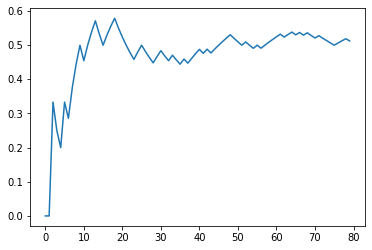

In [17]:
# Let's find the reasonable number of trees
m = DecisionTreeClassifier()
m.fit(train_x, train_y);

plt.plot([accuracy_score(m.predict(train_x[:i+1]), valid_y[:i+1]) for i in range(80)]);

### **Tree Variance for Prediction Confidence**

How can we know the confidence of our random forest estimates? One simple way is to use the standard deviation of predictions across the trees, instead of just the mean. This tells us the relative confidence of predictions. In general, we would want to be more cautious of using the results for rows where trees give very different results (higher standard deviations), compared to cases where they are more consistent (lower standard deviations).

In [21]:
m = RandomForestClassifier(n_estimators=65)
m.fit(train_x, train_y)

# Let's get predictions for each tree
preds = np.stack([t.predict(valid_x) for t in m.estimators_])
preds.shape

(65, 178)

In [22]:
# Now let's look at the standard deviation
preds_std = preds.std(0)

preds_std[:5]

array([0.12307692, 0.17269188, 0.        , 0.30999141, 0.        ])

As you can see, the confidence in the predictions varies widely and it seems like the trees are not able to come to a general consensus. For some passengers, there is a low standard deviation because the trees agree. For others it's higher, as the trees don't agree. This is information that would be useful in a production setting; for instance, if you were using a model to decide what items to bid on at auction, a low-confidence prediction might cause you to look more carefully at an item before you made a bid.

### **Feature Importance**

It's critical for us to know how the trees are making their decisions, and which features they're leaning on to do so. We can get these directly from `sklearn`'s random forest by looking in the `feature_importances_` attribute. Here's a simple function we can use to pop them into a DataFrame and sort them:

In [23]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [24]:
# Let's view the most important features to our model
fi = rf_feat_importance(m, train_x)
fi[:10]

,cols,imp
15,Surname,0.114808
20,Age_Fare,0.113149
9,Mal_CNaN,0.097587
18,Fare,0.091634
3,Sex,0.090739
17,Age,0.083481
13,Title,0.059649
8,Fem_HC,0.052368
2,Pclass,0.040595
12,Ticket_Freq,0.039563


We can also plot it

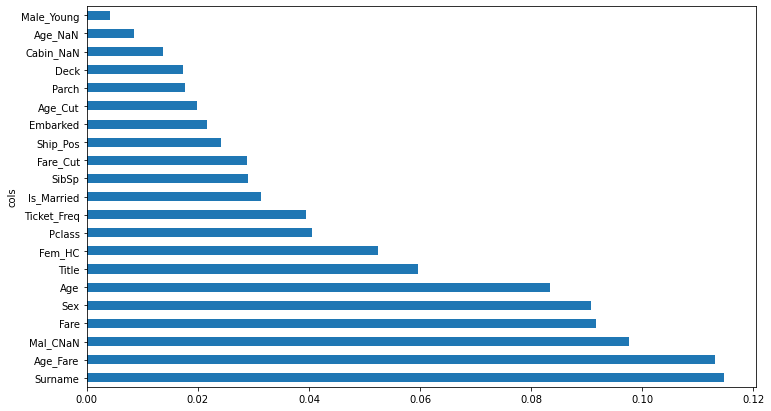

In [25]:
fi[:30].plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

We can remove the features that are of very low importance and see if that has any effect on the model.

In [26]:
to_keep = fi[fi.imp>0.005].cols
list(to_keep)

['Surname',
 'Age_Fare',
 'Mal_CNaN',
 'Fare',
 'Sex',
 'Age',
 'Title',
 'Fem_HC',
 'Pclass',
 'Ticket_Freq',
 'Is_Married',
 'SibSp',
 'Fare_Cut',
 'Ship_Pos',
 'Embarked',
 'Age_Cut',
 'Parch',
 'Deck',
 'Cabin_NaN',
 'Age_NaN']

In [ ]:
print(len(list(to_keep)))
len(full_df.columns)

In [ ]:
xs_imp = train_x[to_keep]
valid_xs_imp = valid_x[to_keep]

# Retrain
m = RandomForestClassifier(n_estimators=40)
m.fit(xs_imp, train_y);

In [ ]:
preds = m.predict(valid_xs_imp)
accuracy_score(valid_y, preds)

0.8314606741573034

### **Cross Validation**


In [28]:
from sklearn import model_selection
from sklearn.ensemble import ExtraTreesClassifier

seed = 42

kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = ExtraTreesClassifier(n_estimators=40, max_features=7)
model_selection.cross_val_score(model, train_x, train_y, cv=kfold)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


array([0.73611111, 0.79166667, 0.73611111, 0.76056338, 0.85915493,
       0.76056338, 0.87323944, 0.8028169 , 0.77464789, 0.84507042])

### **Final Model**

#### **Voting Ensemble**

In [ ]:
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

estimators = []

model1 = KNeighborsClassifier(n_neighbors=5)
estimators.append(('knn', model1))

model2 = RandomForestClassifier(n_estimators=75)
estimators.append(('rf', model2))

model3 = SVC(kernel='linear')
estimators.append(('svc', model3))

# Create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, train_x, train_y, cv=kfold)
print(results.mean())

0.8259780907668232


#### **Neural Network**

We can also give the data a go through a neural net. Although tabular data doesn't achieve groundbreaking results with neural nets, like CV or even NLP, at can still be worth it to try the data on an NN and see how it stacks up to tree models.

In [14]:
dls = tdf.dataloaders(64)

In [15]:
learn = tabular_learner(dls, n_out=dls.c,layers=[5], metrics=[accuracy])

In [16]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(3, 3)
    (4): Embedding(8, 5)
    (5): Embedding(3, 3)
    (6): Embedding(3, 3)
    (7): Embedding(5, 4)
    (8): Embedding(3, 3)
    (9): Embedding(3, 3)
    (10): Embedding(6, 4)
    (11): Embedding(6, 4)
    (12): Embedding(10, 6)
    (13): Embedding(18, 8)
    (14): Embedding(3, 3)
    (15): Embedding(668, 61)
    (16): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=128, out_features=5, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=5, out_features=2, bias=True)
    )
  )
)

In [24]:
layers = learn.model.layers
layers.append(layers[2])
layers

AttributeError: ignored

In [96]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(3, 3)
    (4): Embedding(8, 5)
    (5): Embedding(3, 3)
    (6): Embedding(3, 3)
    (7): Embedding(5, 4)
    (8): Embedding(3, 3)
    (9): Embedding(3, 3)
    (10): Embedding(6, 4)
    (11): Embedding(6, 4)
    (12): Embedding(10, 6)
    (13): Embedding(18, 8)
    (14): Embedding(3, 3)
    (15): Embedding(668, 61)
    (16): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.2, inplace=True)
  (bn_cont): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=128, out_features=5, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=5, out_features=2, bias=True)
    )
  )
)

SuggestedLRs(lr_min=0.10964782238006592, lr_steep=0.12022644281387329)

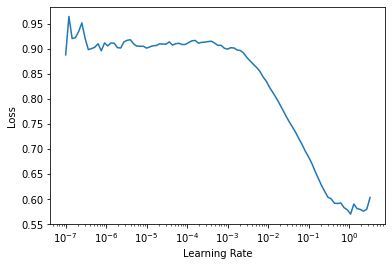

In [97]:
learn.lr_find()

In [98]:
# Let's try a fit-one-cycle
learn.fit(20, 0.11)

epoch,train_loss,valid_loss,accuracy,time
0,0.556527,0.883890,0.764045,00:00
1,0.375876,1.266615,0.752809,00:00
2,0.264265,0.932901,0.803371,00:00
3,0.204514,0.792907,0.792135,00:00
4,0.165254,0.774230,0.831461,00:00
5,0.140071,0.707474,0.825843,00:00
6,0.119281,0.714492,0.803371,00:00
7,0.101249,0.893213,0.803371,00:00
8,0.089098,0.711072,0.814607,00:00
9,0.080646,0.823857,0.797753,00:00


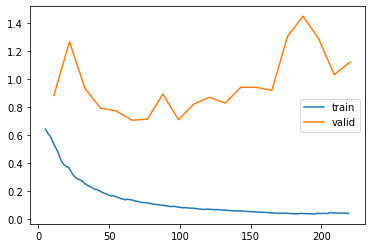

In [99]:
learn.recorder.plot_loss()

## **Inference and Deployment**

Here the model can finally be put to use, as well as exported for deployment in an external application.



---



## **Exports and Clean Up**

Here you can export any cells with the `#export` comment using `notebook2script.py`, as well as cleaning up any environmental changes such as data downloads to a cloud drive.

### **Exports**

In [ ]:
!python notebook2script.py Tabular.ipynb

### **Clean Up**

In [ ]:
# Tear down the data folder
!rm -rf data
!ls